In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=1000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()

def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.


In [25]:
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

In [26]:
print("Loading 20 newsgroups dataset for categories:")
print(categories)

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


In [27]:
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

3387 documents
4 categories



In [28]:
labels = dataset.target
true_k = np.unique(labels).shape[0]

In [29]:
## извлечение признаков из данных
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words='english', alternate_sign=False,
                                   norm=None)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words='english',
                                       alternate_sign=False, norm='l2')
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)
    print(vectorizer)
X = vectorizer.fit_transform(dataset.data)
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=1000,
                min_df=2, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)
done in 1.088373s
n_samples: 3387, n_features: 1000



In [30]:
# #############################################################################
# создание таблицы данных для удобного хранения и визуализации
df = pd.DataFrame(data=X.toarray(),columns=vectorizer.get_feature_names())
df['__labels__'] = labels
df.head(5)

,00,000,10,100,11,12,128,13,14,15,...,xv,year,years,yes,york,young,zip,zoo,zoology,__labels__
0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.098475,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.00000,0.0,0.185695,0.0,0.0,0.0,0.146367,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.03921,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.028484,...,0.0,0.031561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [31]:
# #############################################################################
# импорт библиотеки TSNE и создание объекта для нелинейного снижения размерности (алгортм t-SNE)
from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)
t0 = time()
tsne.fit(df.drop('__labels__', axis=1))
print("done in %fs" % (time() - t0))

done in 52.563396s


In [32]:
# #############################################################################
# подготовка к кластеризации k-means

if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)
print("Clustering sparse data with %s" % km)

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=4, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=False)


In [33]:
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

done in 0.056s



In [34]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))
print("Accuracy score: %0.3f"
      % metrics.accuracy_score(labels, km.labels_))
print()

Homogeneity: 0.497
Completeness: 0.511
V-measure: 0.504
Adjusted Rand-Index: 0.449
Silhouette Coefficient: 0.015
Accuracy score: 0.297



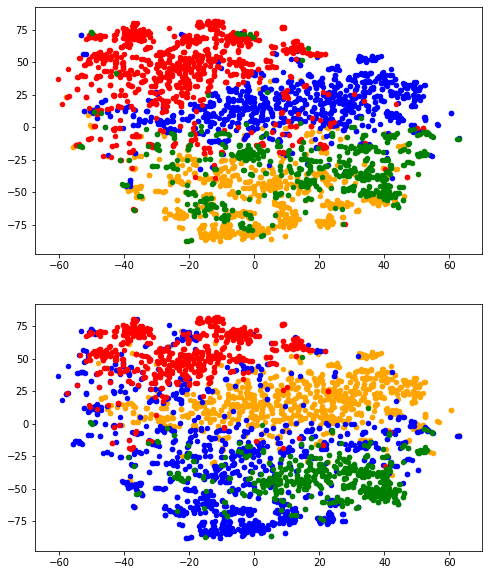

In [35]:
fig, axs = plt.subplots(2,1,figsize=(8,10))
axs[0].scatter(tsne.embedding_[df['__labels__'] == 0, 0], 
            tsne.embedding_[df['__labels__'] == 0, 1], color='orange', s=20);
axs[0].scatter(tsne.embedding_[df['__labels__'] == 1, 0], 
            tsne.embedding_[df['__labels__'] == 1, 1], color='blue', s=20);
axs[0].scatter(tsne.embedding_[df['__labels__'] == 2, 0], 
            tsne.embedding_[df['__labels__'] == 2, 1], color='red', s=20);
axs[0].scatter(tsne.embedding_[df['__labels__'] == 3, 0], 
            tsne.embedding_[df['__labels__'] == 3, 1], color='green', s=20);

axs[1].scatter(tsne.embedding_[km.labels_ == 0, 0], 
            tsne.embedding_[km.labels_ == 0, 1], color='orange', s=20);
axs[1].scatter(tsne.embedding_[km.labels_ == 1, 0], 
            tsne.embedding_[km.labels_ == 1, 1], color='blue', s=20);
axs[1].scatter(tsne.embedding_[km.labels_ == 2, 0], 
            tsne.embedding_[km.labels_ == 2, 1], color='red', s=20);
axs[1].scatter(tsne.embedding_[km.labels_ == 3, 0], 
            tsne.embedding_[km.labels_ == 3, 1], color='green', s=20);

In [ ]:
# X?
# X.data
# X.indices
# X.toarray().shape
# labels
# km.labels_

In [36]:
if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

Top terms per cluster:
Cluster 0: graphics university thanks image ac files file 3d posting host
Cluster 1: com article keith don think sgi people posting just like
Cluster 2: space nasa access henry gov digex alaska pat toronto shuttle
Cluster 3: god sandvik jesus com christian bible kent people apple brian


In [37]:
# импорт библиотеки MiniSom для работы с картами кохонена
from minisom import MiniSom

In [38]:
som_shape = (1, 4)
som = MiniSom(som_shape[0], som_shape[1], opts.n_features, sigma=0.3, learning_rate=0.5,
             neighborhood_function='gaussian', random_seed=15) # initialization of 100x100 SOM

In [39]:
t0 = time()
som.train(X.toarray(), 2000, verbose=True) # trains the SOM with 100 iterations
print("done in %fs" % (time() - t0))

 [  705 / 2000 ]  35% - 0:00:00 left 

 [ 1464 / 2000 ]  73% - 0:00:00 left 

 [ 2000 / 2000 ] 100% - 0:00:00 left 


 quantization error: 1.0032453743667717
done in 0.663013s


In [40]:
winner_coordinates = np.array([som.winner(x) for x in X.toarray()]).T
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

In [41]:
winner_coordinates.shape

(2, 3387)

In [42]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, cluster_index))
print("Completeness: %0.3f" % metrics.completeness_score(labels, cluster_index))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, cluster_index))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, cluster_index))
print("Accuracy score: %0.3f"
      % metrics.accuracy_score(labels, cluster_index))
print()

Homogeneity: 0.177
Completeness: 0.244
V-measure: 0.205
Adjusted Rand-Index: 0.142
Accuracy score: 0.335



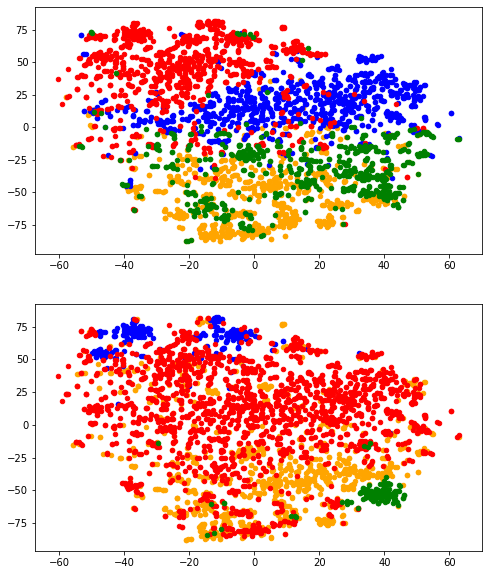

In [43]:
fig, axs = plt.subplots(2,1,figsize=(8,10))
axs[0].scatter(tsne.embedding_[df['__labels__'] == 0, 0], 
            tsne.embedding_[df['__labels__'] == 0, 1], color='orange', s=20);
axs[0].scatter(tsne.embedding_[df['__labels__'] == 1, 0], 
            tsne.embedding_[df['__labels__'] == 1, 1], color='blue', s=20);
axs[0].scatter(tsne.embedding_[df['__labels__'] == 2, 0], 
            tsne.embedding_[df['__labels__'] == 2, 1], color='red', s=20);
axs[0].scatter(tsne.embedding_[df['__labels__'] == 3, 0], 
            tsne.embedding_[df['__labels__'] == 3, 1], color='green', s=20);

axs[1].scatter(tsne.embedding_[cluster_index == 0, 0], 
            tsne.embedding_[cluster_index == 0, 1], color='orange', s=20);
axs[1].scatter(tsne.embedding_[cluster_index == 1, 0], 
            tsne.embedding_[cluster_index == 1, 1], color='blue', s=20);
axs[1].scatter(tsne.embedding_[cluster_index == 2, 0], 
            tsne.embedding_[cluster_index == 2, 1], color='red', s=20);
axs[1].scatter(tsne.embedding_[cluster_index == 3, 0], 
            tsne.embedding_[cluster_index == 3, 1], color='green', s=20);

In [23]:
np.unique(cluster_index)

array([0, 1, 2, 3], dtype=int64)